# Transfer Learning

Transfer Learning은 특정 도메인에 해당하는 문제를 해결하면서 얻은 지식을 저장하고 다른 관련 문제에 적용하는데 초점을 맞춘 학습 방법

Transfer Learning을 고려하는 이유

1. 일반적으로 CNN 기반의 딥러닝 모델을 제대로 훈련시키기 위해서는 수많은 데이터가 필요하지만 현실적으로 데이터를 만드는데 많은 시간과 비용이 필요
2. 모델의 복잡도가 높은 CNN 모델은 처음부터 학습시킬 때 학습 속도가 느린 문제가 종종 발생

# 필요한 Package 불러오기

In [1]:
import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, models, transforms

plt.ion()

In [2]:
# HyperParameters
epochs = 25
batch_size = 4
learning_rate = 0.001
num_class = 2

# 재현성을 위한 Seed / Random State 고정

In [3]:
seed = 777
np.random.seed(seed)
torch.manual_seed(seed)

# 데이터 정의

데이터 종류: 고양이 / 강아지 이미지

목적: 고양이와 강아지를 분류하는 모델 학습

Train: 데이터 증강(Data Augmentation) 기법과 데이터 정규화 진행(Normalization)

Validation: 데이터 증강 기법 제외

In [4]:
# Data 경로 설정
data_dir = './dog_cat'

# Data Transformation Option -- Data Augmentation, Normalization
data_transforms = {
    'train':transforms.Compose([ # Composes several transforms together.
        transforms.RandomResizedCrop(224), # size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Sequence of means for each channel, Sequence of standard deviations for each channel.
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define Train & Validation dataset & Data loader
image_datasets = {x: datasets.ImageFolder(
    os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_name = image_datasets['train'].classes

# 데이터 증강 기법을 이해하기 위해 훈련 이미지 시각화 

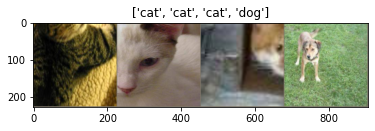

In [7]:
def visualization(image: torch.Tensor, title=None):
    image = image.numpy().transpose((1, 2, 0))  # (228, 906, 3) height, width, channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Given an interval, values outside the interval are clipped to the interval edges.
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    
    # pause a bit so that plots are updated
    plt.pause(0.001)

    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) #torch.Size([4,3,224,224])

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) # torch.Size([3, 228, 906])

visualization(out, title=[class_name[x] for x in classes])

# Pretrained AlexNet 모델 불러오기

In [8]:
alexnet = models.alexnet(pretrained=True)

# Fine Tuning: 마지막 Fully Connected Layer (Linear)

Pretrained AlexNet을 로드하고 마지막 Fully Connected Layer를 재설정

** Fine Tuining 하고자 하는 레이어를 제외한 나머지 레이어는 고정해야 함
즉, Gradient Backpropagation 시, 모델 파라미터가 계산되지 않도록 고정

requires_grad == False

In [9]:
for param in alexnet.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_in = alexnet.classifier[-1].in_features
alexnet.classifier[-1] = nn.Linear(num_in, num_class)

# Model, Optimizer, Criterion, Lr Shceduler 선언

In [10]:
alexnet = alexnet
optimizer = torch.optim.SGD(alexnet.classifier[-1].parameters(),
                           lr=learning_rate,
                           momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Scheduling a learning rate according to specific conditions
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=7,
                                               gamma=0.1)

# 모델 학습

모델 학습 및 검증을 위한 Definition 작성

In [11]:
def trainer(model: nn.Module, 
            criterion: nn, 
            optimizer: torch.optim, 
            lr_scheduler: torch.optim.lr_scheduler) -> nn.Module:
    
    since = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs-1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                lr_scheduler.step()
                model.train()  # Set model to training mode
            
            else:
                model.eval()  # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, targets in dataloaders[phase]:
 
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, targets)
                    
                    # Backward + optimize only if in training phase
                    # Zero the parameter gradients
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == targets.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print(f'Training Complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')
    
    # load best model weights
    model.load_state_dict(best_model)
    
    return model                              

In [12]:
alexnet_ft = trainer(alexnet, criterion, optimizer, lr_scheduler)

Epoch 0/24
----------


C:\Users\youngjae\Anaconda3\envs\rl\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4318, Acc: 0.8465
val Loss: 0.0612, Acc: 0.9706
Epoch 1/24
----------
train Loss: 0.2095, Acc: 0.9059
val Loss: 0.0964, Acc: 0.9804
Epoch 2/24
----------
train Loss: 0.2766, Acc: 0.9109
val Loss: 0.0405, Acc: 0.9804
Epoch 3/24
----------
train Loss: 0.2063, Acc: 0.9307
val Loss: 0.2908, Acc: 0.9412
Epoch 4/24
----------
train Loss: 0.4057, Acc: 0.9010
val Loss: 0.1681, Acc: 0.9804
Epoch 5/24
----------
train Loss: 0.2500, Acc: 0.9059
val Loss: 0.1533, Acc: 0.9608
Epoch 6/24
----------
train Loss: 0.2868, Acc: 0.9257
val Loss: 0.1253, Acc: 0.9804
Epoch 7/24
----------
train Loss: 0.1433, Acc: 0.9455
val Loss: 0.1280, Acc: 0.9706
Epoch 8/24
----------
train Loss: 0.1241, Acc: 0.9406
val Loss: 0.1158, Acc: 0.9804
Epoch 9/24
----------
train Loss: 0.0762, Acc: 0.9653
val Loss: 0.1085, Acc: 0.9804
Epoch 10/24
----------
train Loss: 0.2265, Acc: 0.9356
val Loss: 0.0957, Acc: 0.9902
Epoch 11/24
----------
train Loss: 0.2407, Acc: 0.9604
val Loss: 0.0905, Acc: 0.9804
Epoch 12/24


# Visulaizing the model predictions

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloaders['val']):
   
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_name[preds[j]]))
                visualization(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

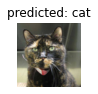

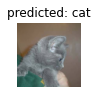

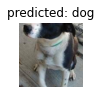

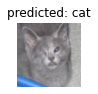

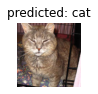

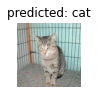

In [14]:
visualize_model(alexnet_ft)